In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
!mkdir /home/aistudio/external-libraries
# 安装pandas到指定目录
!pip install pandas -t /home/aistudio/external-libraries

# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [1]:
#导入需要的包
import os
import numpy as np
from PIL import Image
import cv2
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset
from paddle.vision.transforms import Compose, Normalize

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# 一、数据处理

In [2]:

class MyDataSet(Dataset):
    def __init__(self, data_dir, label_path, transform):
        super(MyDataSet, self).__init__()
        self.data_list = []
        with open(label_path, encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        self.transform = transform
    def __getitem__(self, index):
        image_path, label = self.data_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = image.astype('float32')
        image/=255.0
        # 应用图像变换
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([label],dtype="int64")
        return image, label
 
    def __len__(self):
        return len(self.data_list)

In [3]:
import paddle.vision.transforms
import paddle.io
import numpy as np
import cv2
import paddle.vision.transforms as T
transforms = T.Compose([
T.Resize((47,47)), # 随机裁剪大小
T.RandomHorizontalFlip(0.5), # 随机水平翻转
T.ToTensor(),  # 数据的格式转换和标准化、 HWC => CHW
T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 图像归一化
])
train_dataset = MyDataSet('/home/aistudio/dataset','/home/aistudio/dataset/train.txt',transforms)
test_dataset = MyDataSet('/home/aistudio/dataset','/home/aistudio/dataset/eval.txt',transforms)
print('train_dataset images:',len(train_dataset),'test_dataset images:',len(test_dataset))

train_dataset images: 14550 test_dataset images: 1620


batch_id=0,训练数据shape:[64, 3, 47, 47],标签数据shape:[64, 1]
train_data0 的标签为:Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [4])


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

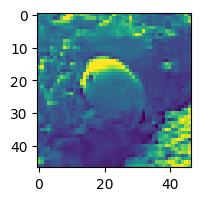

In [4]:
import cv2
import matplotlib.pyplot as plt
train_loader = paddle.io.DataLoader(train_dataset,batch_size = 64,shuffle = True,num_workers = 1)
for batch_id,data in enumerate(train_loader()):
    images, labels = data
    print("batch_id={},训练数据shape:{},标签数据shape:{}".format(batch_id,images.shape,labels.shape))
    plt.figure(figsize=(2,2))
    plt.imshow(images[0][0])
    print('train_data0 的标签为:'+str(labels[0])) 
    break

# 二、模型设计

In [5]:
import paddle.nn.functional as F
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5,stride=2)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=3,stride=2)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=200, out_features=5)
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.linear1(x)
        x=F.softmax(x)
        return x
model = MyCNN()
paddle.summary(model,(1, 3, 47, 47))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-1       [[1, 3, 47, 47]]     [1, 20, 22, 22]         1,520     
  MaxPool2D-1    [[1, 20, 22, 22]]     [1, 20, 11, 11]           0       
   Conv2D-2      [[1, 20, 11, 11]]      [1, 50, 5, 5]          9,050     
  MaxPool2D-2     [[1, 50, 5, 5]]       [1, 50, 2, 2]            0       
   Linear-1          [[1, 200]]             [1, 5]             1,005     
Total params: 11,575
Trainable params: 11,575
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.10
Params size (MB): 0.04
Estimated Total Size (MB): 0.17
---------------------------------------------------------------------------



{'total_params': 11575, 'trainable_params': 11575}

# 三、模型训练

In [6]:

def draw_train_process(title, iters, costs, accs, label_cost, lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red', label=label_cost) 
    plt.plot(iters, accs,color='green', label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

def draw_process(title, color, iters, data, label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data, color=color, label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
import numpy as np
epochs = 10
optim = paddle.optimizer.Adam(learning_rate=0.001,parameters=model.parameters())
loss_fn = paddle.nn.CrossEntropyLoss()
accs = []
losses = []
for epoch in range(epochs):
    for batch_id,data in enumerate(train_loader()):
        x_data = data[0]
        y_data = data[1]
        x_data = paddle.squeeze(x_data, axis=1)
        predicts = model(x_data)
        loss = loss_fn(predicts,y_data)
        y_data = paddle.squeeze(y_data, axis=1)
        y_data = paddle.reshape(y_data,shape = [-1,1])
        acc = paddle.metric.accuracy(predicts,y_data)
        loss.backward()
        if(batch_id > 50):
            break
        if(batch_id+1)%10==0:
            print("loss is:{},acc is{}".format(loss.numpy(),acc.numpy()))
            losses.append(loss.numpy())
            accs.append(acc.numpy())
        optim.step()
        optim.clear_grad() 


loss is:[1.5055861],acc is[0.4375]
loss is:[1.3350673],acc is[0.59375]
loss is:[1.2714702],acc is[0.640625]
loss is:[1.132736],acc is[0.78125]
loss is:[1.1303182],acc is[0.765625]
loss is:[1.0593501],acc is[0.859375]
loss is:[1.0706859],acc is[0.859375]
loss is:[1.0984102],acc is[0.828125]
loss is:[1.020525],acc is[0.9375]
loss is:[1.0575267],acc is[0.859375]
loss is:[1.0137441],acc is[0.890625]
loss is:[1.0494359],acc is[0.875]
loss is:[1.0340819],acc is[0.859375]
loss is:[0.9641112],acc is[0.9375]
loss is:[0.97451144],acc is[0.953125]
loss is:[1.0145056],acc is[0.90625]
loss is:[1.0792905],acc is[0.84375]
loss is:[1.0017657],acc is[0.921875]
loss is:[1.0354468],acc is[0.890625]
loss is:[0.99732137],acc is[0.9375]
loss is:[1.0051795],acc is[0.90625]
loss is:[0.953861],acc is[0.953125]
loss is:[0.94319296],acc is[0.96875]
loss is:[1.0134053],acc is[0.890625]
loss is:[0.9948147],acc is[0.921875]
loss is:[1.0107372],acc is[0.90625]
loss is:[1.0113823],acc is[0.890625]
loss is:[0.9734363]

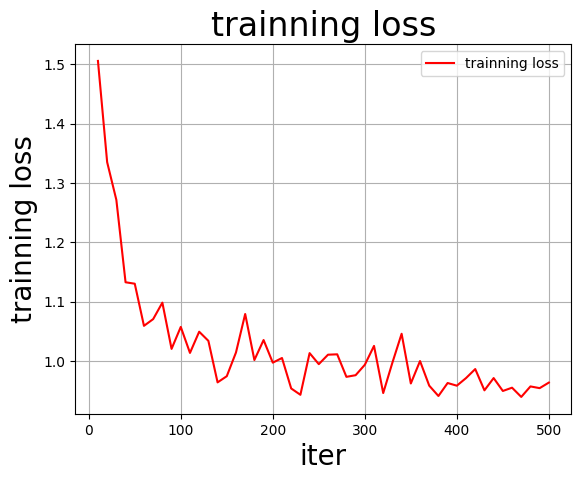

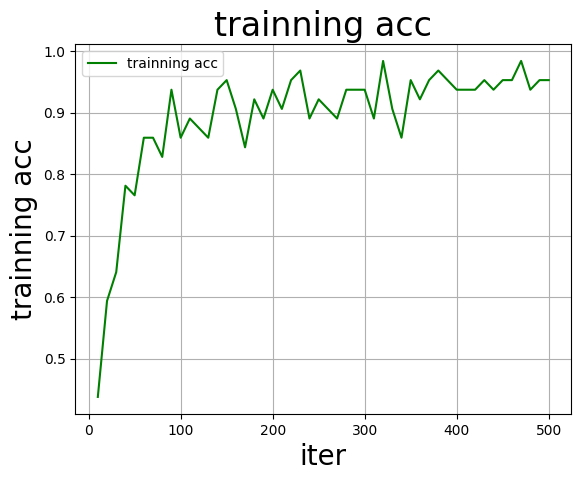

In [8]:
a = list(range(10, 510, 10))
draw_process("trainning loss","red",a,losses,"trainning loss")
draw_process("trainning acc","green",a,accs,"trainning acc")

# 四、模型评估与推理

In [9]:
test_loader = paddle.io.DataLoader(test_dataset,batch_size = 64,drop_last=True)
loss_fn = paddle.nn.CrossEntropyLoss()
model.eval()
for batch_id,data in enumerate(test_loader()):
    x_data = data[0]
    y_data = data[1]
    x_data = paddle.squeeze(x_data, axis=1)
    predicts = model(x_data)
    loss = loss_fn(predicts,y_data)
    y_data = paddle.squeeze(y_data, axis=1)
    y_data = paddle.reshape(y_data,shape = [-1,1])
    acc = paddle.metric.accuracy(predicts,y_data)
    if(batch_id+1)%5==0:
        print("batch_id: {},loss is:{},acc is{}".format(batch_id+1,loss.numpy(),acc.numpy()))

batch_id: 5,loss is:[1.0033278],acc is[0.90625]
batch_id: 10,loss is:[0.96165144],acc is[0.953125]
batch_id: 15,loss is:[0.9366775],acc is[0.96875]
batch_id: 20,loss is:[1.0725191],acc is[0.828125]
batch_id: 25,loss is:[1.0072718],acc is[0.90625]


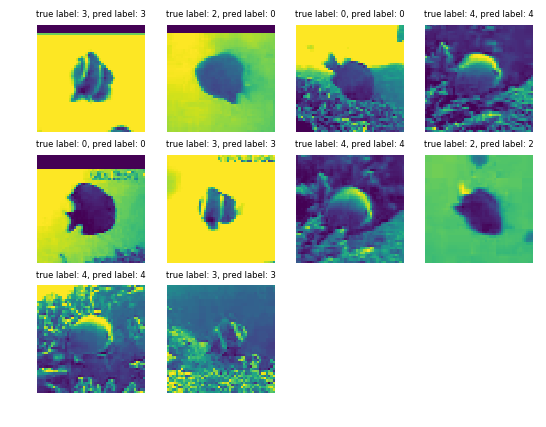

In [13]:
from paddle.io import RandomSampler,BatchSampler
sampler = RandomSampler(test_dataset)
batch_sampler = BatchSampler(sampler=sampler, batch_size=10)
i=1
for img, label in test_loader:
    # 执行推理并打印结果
    pred_label = model(img)[0].argmax()
    #print('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()))# 可视化图片
    plt.subplot(3,4,i)
    i=i+1
    plt.title('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()),fontsize='6')
    plt.imshow(img[0][0])
    plt.axis('off')
    if(i>10):
        break